<summary>Table of Contents</summary>

- [1. Comparison of models](#1-comparison-of-models)
- [2. Sequence length](#2-sequence-length)
- [3. Self-supervised](#3-self-supervised)
- [4. Ablation study](#4-ablation-study)
- [5. TimeLLM](#5-timellm)
- [6. Decomposition](#6-decomposition)

This script summarizes results from all experiments and represents them in plots. On the plots is UK, but in tables is GB. GB here is United Kingdom.

In [1]:
import pandas as pd
import os
from utils.helper import style_dataframe, \
                         map_country_name, \
                         read_results_csv, \
                         group_and_reindex_df, \
                         choose_best_patchtst_model, \
                         calculate_improvement

from utils.plot_final_results import plot_results_models_multiple_countries, \
                                      plot_comparison_for_metrics, \
                                      plot_barplots


# 1. Input length

In [2]:
patchtst_df = read_results_csv('patchtst/patchtst_128.csv',
                               columns_to_extract = ('PatchTST/42', ['RMSE', 'MAE'])
                               )
patchtst_21_df = read_results_csv('patchtst/patchtst_168_21_patch.csv',
                                   columns_to_extract = ('PatchTST/21', ['RMSE', 'MAE'])
                                   )
patchtst_64_df = read_results_csv('patchtst/patchtst_bs128_pl512.csv',
                                   columns_to_extract = ('PatchTST/64', ['RMSE', 'MAE'])
                                   )

all_df_store = pd.concat([patchtst_21_df, patchtst_df, patchtst_64_df], axis=1)

# Change country codes to country names
level_names = all_df_store.index.names
all_df_store.index = pd.MultiIndex.from_tuples(
    [(map_country_name(x[0]), x[1]) for x in all_df_store.index],
    names=level_names
)
# Scale
scale = 10**2
all_df_scale_store = all_df_store * scale

# With best PatchTST configurations
result_df_unscaled = choose_best_patchtst_model(all_df_store)
result_df = result_df_unscaled * scale

# Highlight the minimum values in bold
styled_df = style_dataframe(all_df_scale_store, decimal_places=2)
styled_df


In [16]:
best_vs_base.loc[best_vs_base['rmse_improvement'] != 0].mean()

Model             Metrics
PatchTST          RMSE       0.155818
                  MAE        0.098123
PatchTST/42       RMSE       0.157615
                  MAE        0.099558
mae_improvement              1.440909
rmse_improvement             1.066364
dtype: float64

In [18]:
((0.099558 - 0.098123)/ 0.099558) * 100

1.4413708591976455

In [19]:
((0.157615 - 0.155818)/ 0.157615) * 100

1.140119912444877

In [3]:
# Improvement over base
to_group = ['Country', 'Pred_len']
best_vs_base = pd.concat([result_df_unscaled, all_df_store.loc[:, all_df_store.columns.get_level_values('Model') == 'PatchTST/42']], axis=1)
grouped_means = group_and_reindex_df(best_vs_base, to_group=to_group)
calculate_improvement(grouped_means,
                      base_mae_model='PatchTST', 
                      model_to_compare_mae='PatchTST/42')

Improvement of PatchTST over PatchTST/42 in terms of MAE: 1.11 %
Improvement of PatchTST over PatchTST/42 in terms of RMSE: 0.88 %


In [6]:
best_vs_base = calculate_improvement(best_vs_base, 
                                      base_mae_model='PatchTST', 
                                      model_to_compare_mae='PatchTST/42',
                                      grouped_by_models=False)
best_vs_base.round(4)

Model                   PatchTST         PatchTST/42         mae_improvement  \
Metrics                     RMSE     MAE        RMSE     MAE                   
Country        Pred_len                                                        
Germany        24         0.1448  0.0877      0.1448  0.0877            0.00   
               96         0.1894  0.1250      0.1941  0.1283            2.55   
               168        0.1968  0.1327      0.1981  0.1339            0.93   
Spain          24         0.0988  0.0592      0.0988  0.0592            0.00   
               96         0.1361  0.0861      0.1361  0.0861            0.00   
               168        0.1439  0.0916      0.1439  0.0916            0.00   
France         24         0.0998  0.0544      0.1000  0.0548            0.81   
               96         0.1385  0.0789      0.1390  0.0808            2.39   
               168        0.1450  0.0856      0.1460  0.0868            1.37   
United Kingdom 24         0.1570  0.0990      0.1582  0.0996            0.61   
               96         0.2027  0.1390      0.2045  0.1395            0.41   
               168        0.2085  0.1449      0.2115  0.1468            1.31   
Italy          24         0.1000  0.0566      0.1004  0.0567            0.11   
               96         0.1352  0.0789      0.1371  0.0807            2.23   
               168        0.1411  0.0845      0.1448  0.0872            3.13   

Model                   rmse_improvement  
Metrics                                   
Country        Pred_len                   
Germany        24                   0.00  
               96                   2.44  
               168                  0.65  
Spain          24                   0.00  
               96                   0.00  
               168                  0.00  
France         24                   0.13  
               96                   0.38  
               168                  0.68  
United Kingdom 24                   0.77  
               96                   0.90  
               168                  1.42  
Italy          24                   0.36  
               96                   1.39  
               168                  2.61

In [ ]:
# Average improvement
(best_vs_base.loc[best_vs_base['mae_improvement']!=0]['mae_improvement'].mean()).round(2)


1.44

In [ ]:
# Average improvement
(best_vs_base.loc[best_vs_base['rmse_improvement']!=0]['rmse_improvement'].mean()).round(2)

1.07

In [ ]:
# Save styled dataframe to HTML
path = './stored_elements/tables'

if not os.path.exists(path):
    os.makedirs(path)
styled_df.to_html(os.path.join(path, 'patchtst_input_length_10_power_2.html'), index=True)

# 2. Comparison of models

In [6]:
# Read data
naive_df = read_results_csv('naive/metrics_persistence_countries_minmax.csv',
                            columns_to_extract = ('Persistence', ['RMSE', 'MAE'])
                            )
arima_df = read_results_csv('arima/metrics_arima_countries_minmax.csv',
                             columns_to_extract = ('(S)ARIMA', ['RMSE', 'MAE'])
                             )
informer_df = read_results_csv('informer/informer.csv',
                               columns_to_extract = ('Informer', ['RMSE', 'MAE'])
                               )

# Concat all dfs with default PatchTST
all_df = pd.concat([patchtst_df, informer_df, arima_df, naive_df], axis=1)

# Scale
scale = 10**2

# Change country codes to country names
level_names = all_df.index.names
all_df.index = pd.MultiIndex.from_tuples(
    [(map_country_name(x[0]), x[1]) for x in all_df.index], 
    names=level_names
)
all_df_scale = all_df * scale

# Highlight the minimum values in bold
styled_df = style_dataframe(all_df_scale, decimal_places=2)
styled_df

In [7]:
# Concat all dfs with best PatchTST - FINAL TABLE
all_df_with_result = pd.concat(
    [result_df, all_df_scale.loc[:, all_df_scale.columns.get_level_values('Model') != 'PatchTST/42']],
    axis=1
)

unscaled_for_plots = all_df_with_result / scale

all_df_with_result.columns.names = ['Model', 'Metrics']

# Highlight the minimum values in bold.
styled_df = style_dataframe(all_df_with_result, decimal_places=2)
styled_df

In [8]:
# Save styled dataframe to HTML
path = './stored_elements/tables'

if not os.path.exists(path):
    os.makedirs(path)
styled_df.to_html(os.path.join(path, 'model_comparison_10_power_2.html'), index=True)

Create plots.

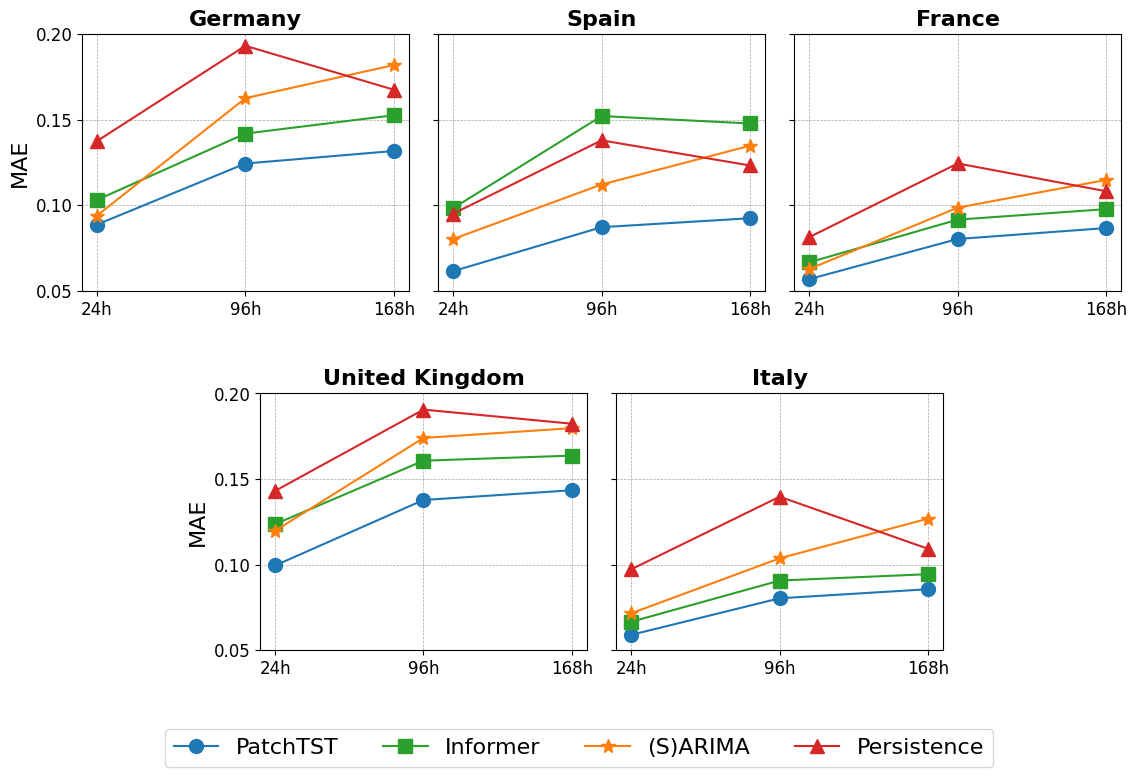

In [9]:
plot_results_models_multiple_countries(unscaled_for_plots, 
                                       function="lines", 
                                       eval_metric='MAE',
                                       decimal_places=2
                                       )

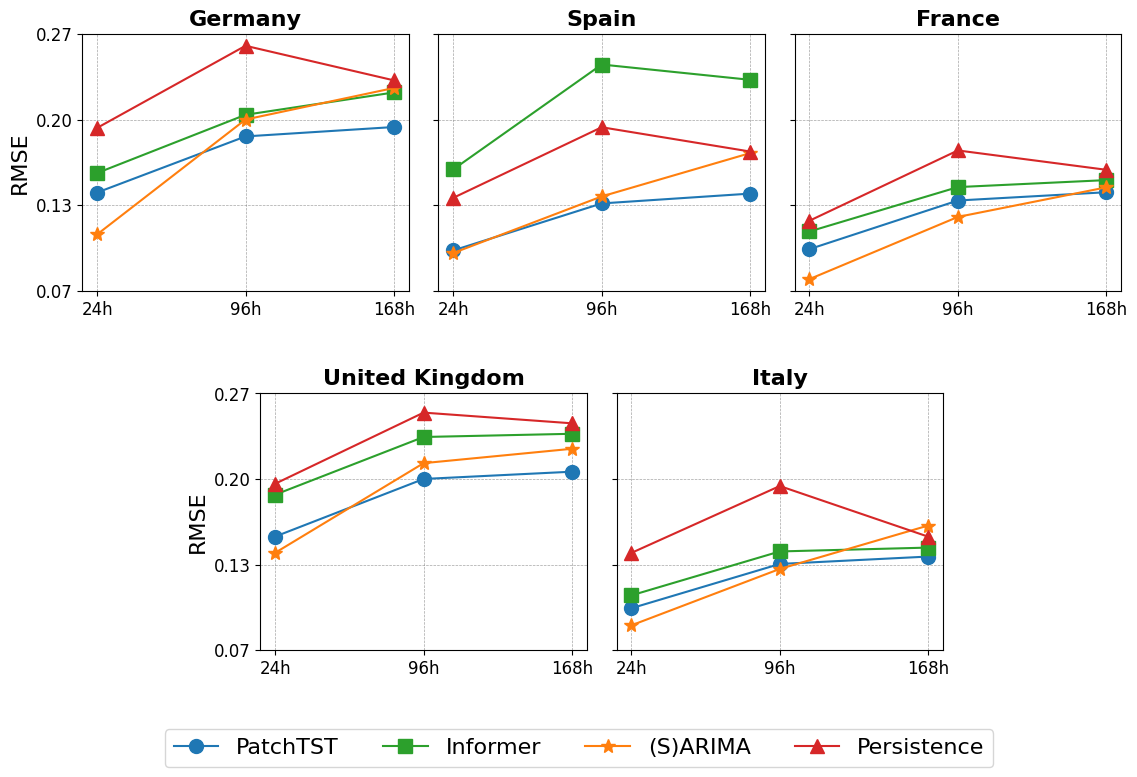

In [10]:
plot_results_models_multiple_countries(unscaled_for_plots, 
                                       function="lines", 
                                       eval_metric='RMSE',
                                       decimal_places=2)

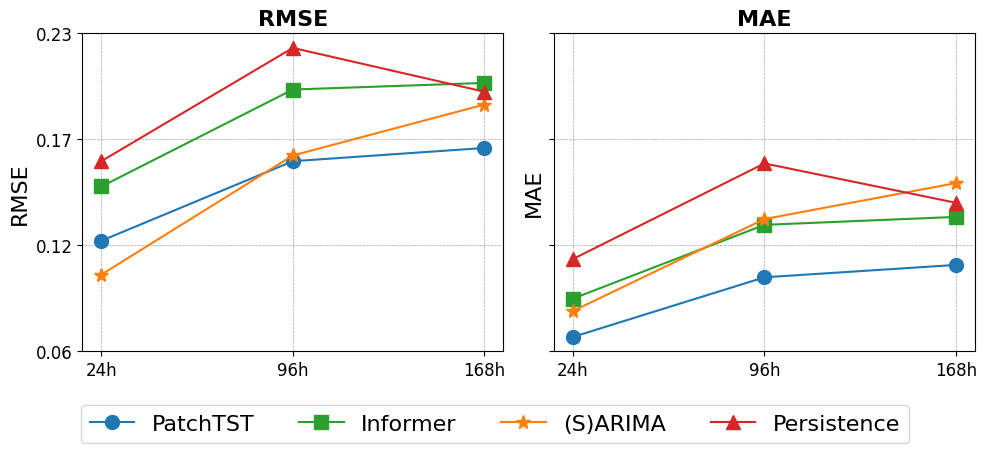

In [11]:
# Averaged by pred_len
to_group = 'Pred_len'
grouped_means = group_and_reindex_df(unscaled_for_plots, to_group=to_group)
plot_comparison_for_metrics(grouped_means, plot_x_axis=to_group, plot_type="lines")

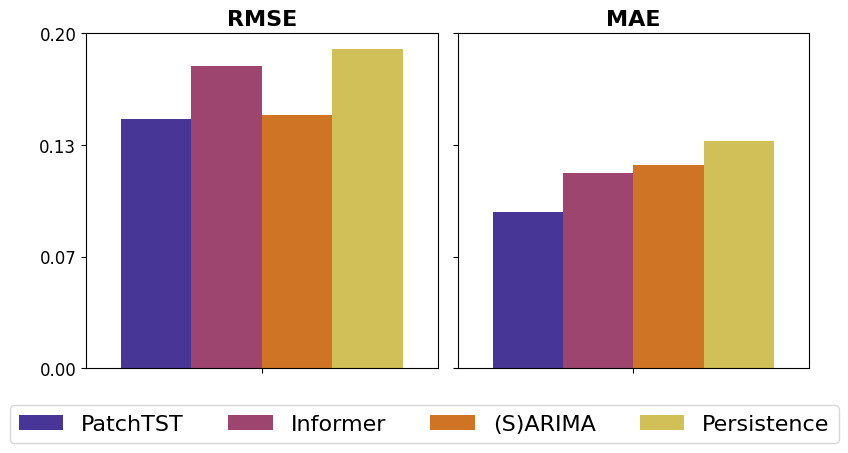

In [12]:
to_group = ['Country', 'Pred_len']
grouped_means = group_and_reindex_df(unscaled_for_plots, to_group=to_group)
plot_barplots(grouped_means, 'Model', col_name='Metrics', palette='CMRmap')

In [13]:
# over best parameters
calculate_improvement(grouped_means, 
                      base_mae_model='PatchTST', 
                      model_to_compare_mae='Informer', 
                      model_to_compare_rmse='(S)ARIMA')

Improvement of PatchTST over Informer in terms of MAE: 20.02 %
Improvement of PatchTST over (S)ARIMA in terms of RMSE: 1.71 %


In [14]:
grouped_means = group_and_reindex_df(all_df, to_group=to_group)

# over baseline PatchTST
calculate_improvement(grouped_means, 
                      base_mae_model='PatchTST/42', 
                      model_to_compare_mae='Informer', 
                      model_to_compare_rmse='(S)ARIMA')

Improvement of PatchTST/42 over Informer in terms of MAE: 19.12 %
Improvement of PatchTST/42 over (S)ARIMA in terms of RMSE: 0.84 %


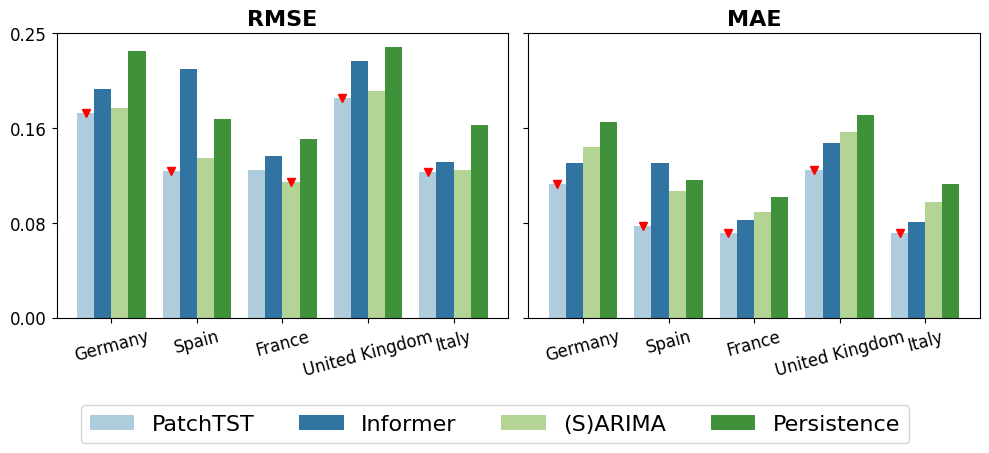

In [15]:
# Averaged by country
to_group = 'Country'
grouped_means = group_and_reindex_df(unscaled_for_plots, to_group=to_group)
plot_comparison_for_metrics(grouped_means, plot_x_axis=to_group, plot_min_markers=True, plot_max_markers=False, palette="Paired")

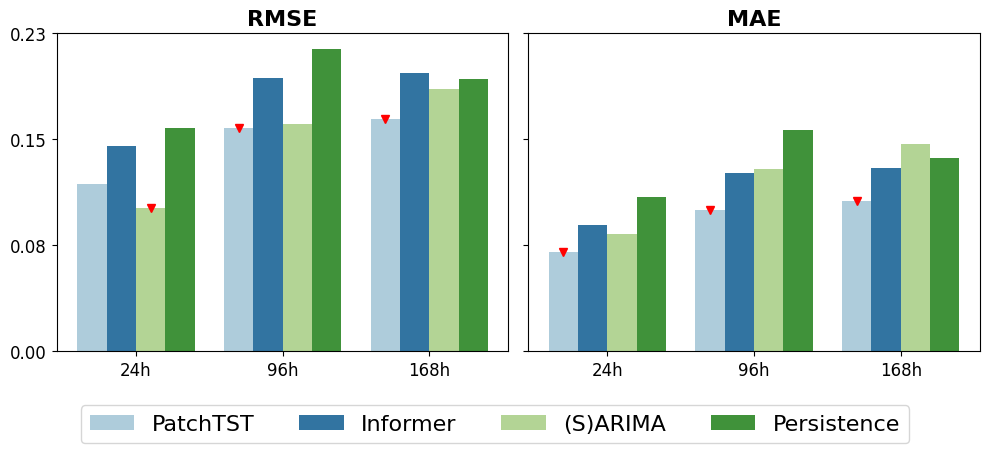

In [16]:
# Averaged by pred_len
to_group = 'Pred_len'
grouped_means = group_and_reindex_df(unscaled_for_plots, to_group=to_group)
plot_comparison_for_metrics(grouped_means, plot_x_axis=to_group, plot_min_markers=True, palette="Paired")

# 3. Self-supervised

In [19]:
# Read data
self_supervised = read_results_csv('patchtst/finetune_results.csv',
                                    columns_to_extract = ('Self-supervised', ['RMSE', 'MAE'])
                                    )

all_df = pd.concat([self_supervised, patchtst_df], axis=1)

# Change country codes to country names
all_df.index = pd.MultiIndex.from_tuples(
    [(map_country_name(x[0]), x[1]) for x in all_df.index],
    names=level_names
)
# Scale
all_df_scale = all_df * scale

# Highlight the minimum values in bold
styled_df = style_dataframe(all_df_scale, decimal_places=2)
styled_df

In [20]:
styled_df.to_html(os.path.join(path, 'self_supervised_10_power_2.html'), index=True)

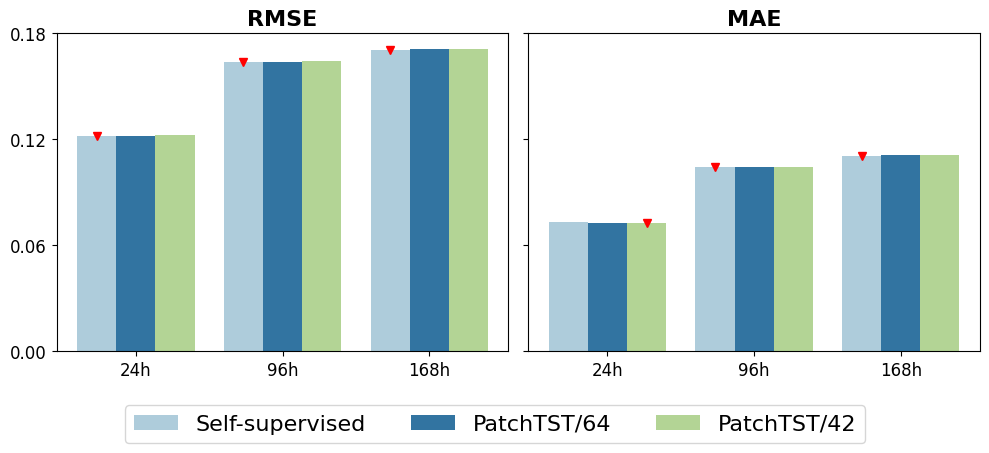

In [ ]:
# all together
# Not visible

all_df = pd.concat([self_supervised, patchtst_64_df, patchtst_df], axis=1)

# Change country codes to country names
all_df.index = pd.MultiIndex.from_tuples(
    [(map_country_name(x[0]), x[1]) for x in all_df.index],
    names=level_names
)

# Averaged by country
to_group = 'Pred_len'
grouped_means = group_and_reindex_df(all_df, to_group=to_group)
plot_comparison_for_metrics(grouped_means, plot_x_axis=to_group, plot_min_markers=True, plot_max_markers=False, palette="Paired")

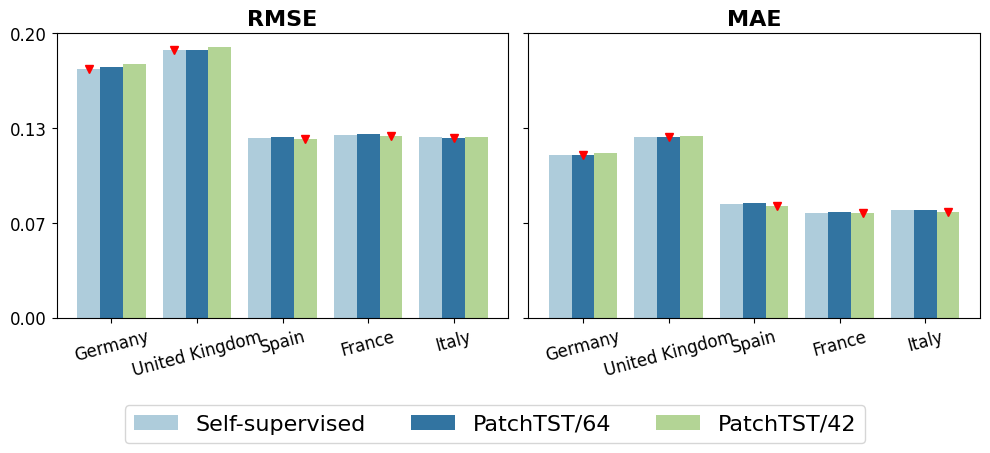

In [22]:
# Averaged by country
to_group = 'Country'
grouped_means = group_and_reindex_df(all_df, to_group=to_group)
plot_comparison_for_metrics(grouped_means, plot_x_axis=to_group, plot_min_markers=True, plot_max_markers=False, palette="Paired")

# 4. Ablation study

In [3]:
# Read data
no_revin = read_results_csv('patchtst/patchtst_no_revin.csv', 
                           columns_to_extract = ('-RevIN', ['RMSE', 'MAE'])
                           )
patchtst_mix_features = read_results_csv('patchtst/patchtst_channel_mixing_MIX_FEATURES.csv',
                                        columns_to_extract = ('CM', ['RMSE', 'MAE'])
                                        )
no_patch = read_results_csv('patchtst/patchtst_no_patching.csv', 
                           columns_to_extract = ('-P', ['RMSE', 'MAE'])
                           )

all_df = pd.concat([patchtst_df, no_revin, patchtst_mix_features, no_patch], axis=1)

# Change country codes to country names
all_df.index = pd.MultiIndex.from_tuples(
    [(map_country_name(x[0]), x[1]) for x in all_df.index],
    names=level_names
)

# Scale
all_df_scale = all_df * scale

# Highlight maximum values in bold
styled_df = style_dataframe(all_df_scale, 'max', decimal_places=2)
styled_df

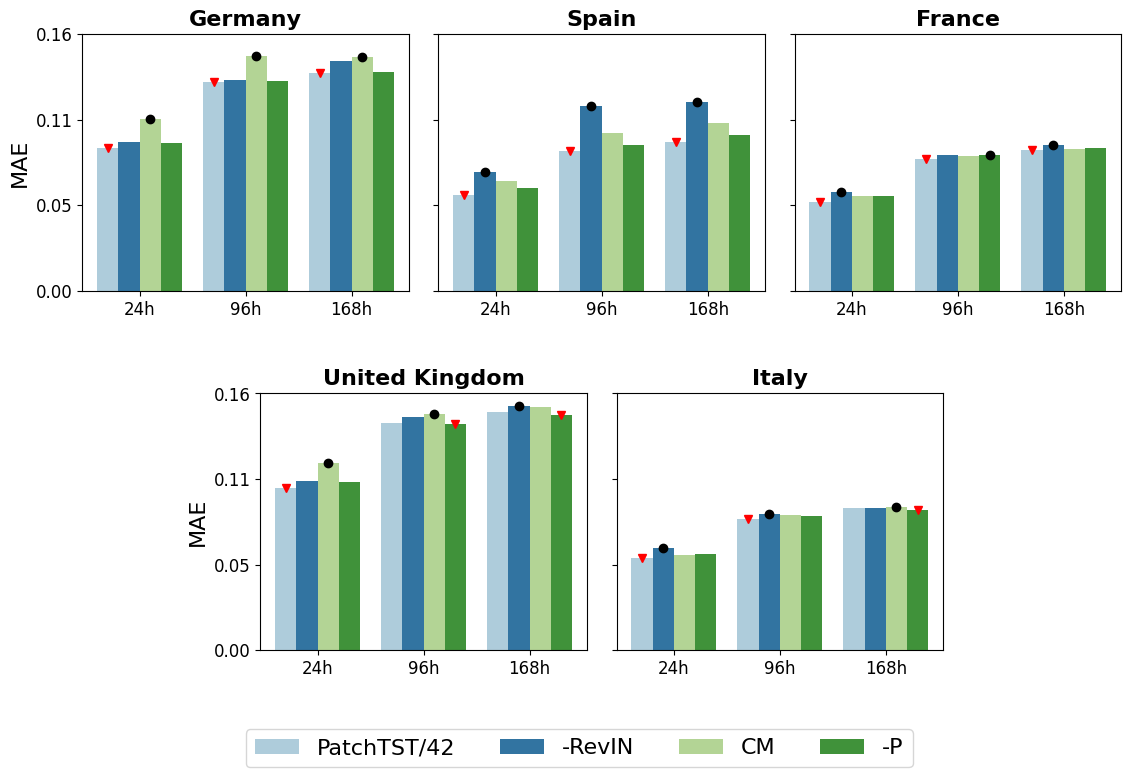

In [4]:
plot_results_models_multiple_countries(all_df, 
                                       function="bars", 
                                       eval_metric='MAE',
                                       palette="Paired",
                                       plot_max_markers=True,
                                       plot_min_markers=True,
                                       decimal_places=2)

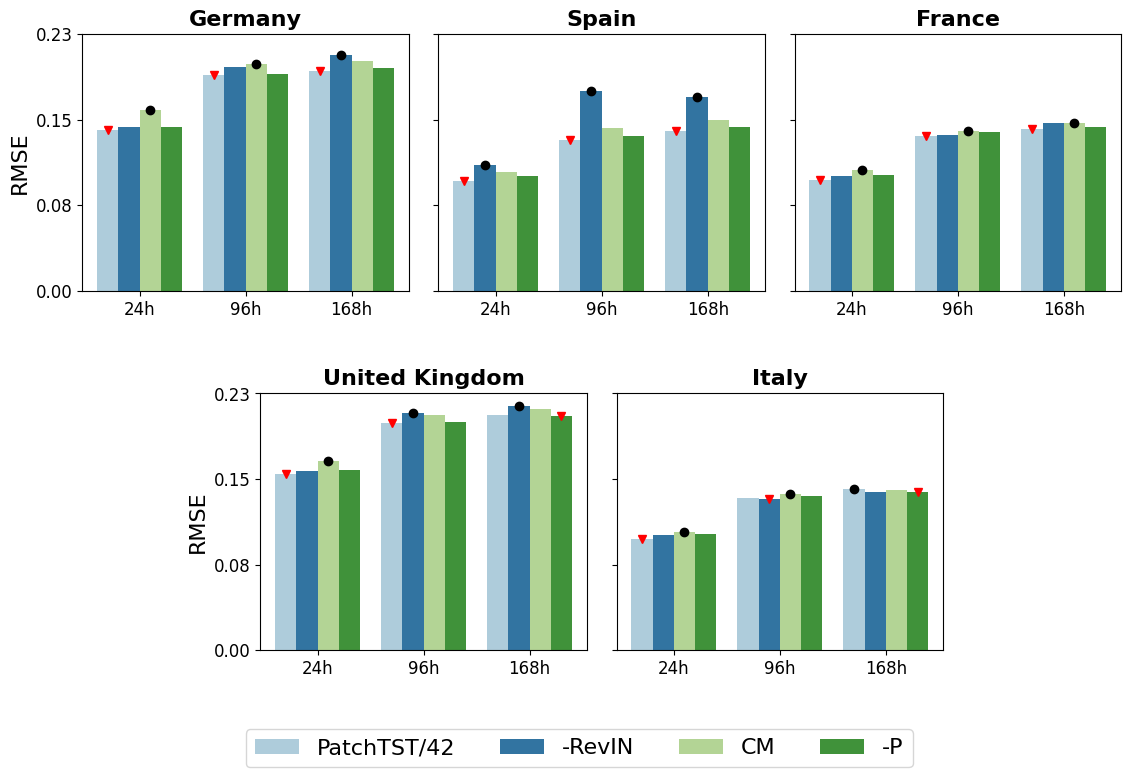

In [9]:
plot_results_models_multiple_countries(all_df, 
                                       function="bars", 
                                       eval_metric='RMSE',
                                       palette="Paired",
                                       plot_max_markers=True,
                                       plot_min_markers=True,
                                       decimal_places=2)

In [26]:
styled_df.to_html(os.path.join(path, 'ablation_10_power_2.html'), index=True)

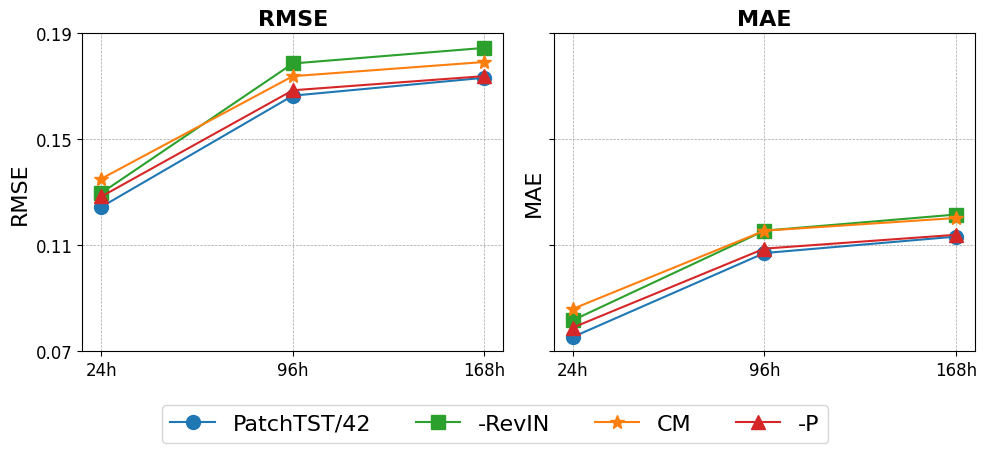

In [27]:
# Averaged by country
# Not clearly visible
to_group = 'Pred_len'
grouped_means = group_and_reindex_df(all_df, to_group=to_group)
plot_comparison_for_metrics(grouped_means, plot_type="lines")

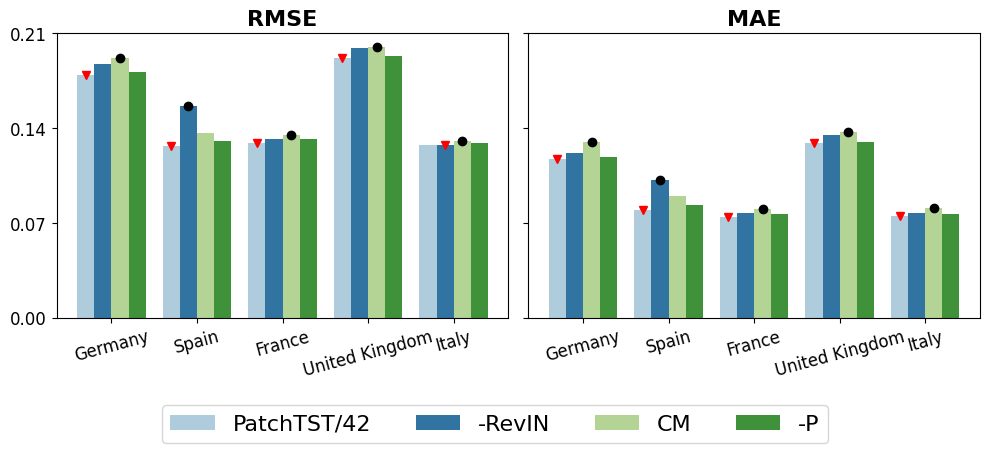

In [7]:
# Averaged by country
to_group = 'Country'
grouped_means = group_and_reindex_df(all_df, to_group=to_group)
plot_comparison_for_metrics(grouped_means,
                             plot_x_axis=to_group, 
                             plot_max_markers=True,
                             plot_min_markers=True,
                             palette="Paired")

# 5. TimeLLM

In [42]:
timellm_df = read_results_csv('timellm/timellm.csv', 
                              columns_to_extract = ('TimeLLM/512', ['RMSE', 'MAE'])
                              )
timellm_df_336 = read_results_csv('timellm/timellm_336.csv', 
                              columns_to_extract = ('TimeLLM/336', ['RMSE', 'MAE'])
                              )
all_df = pd.concat([timellm_df, timellm_df_336, patchtst_64_df, patchtst_df], axis=1)

# Change country codes to country names
all_df.index = pd.MultiIndex.from_tuples(
    [(map_country_name(x[0]), x[1]) for x in all_df.index],
    names=level_names
)

# Scale
all_df_scale = all_df * scale

# Highlight minimum values in bold
styled_df = style_dataframe(all_df_scale, decimal_places=2)
styled_df

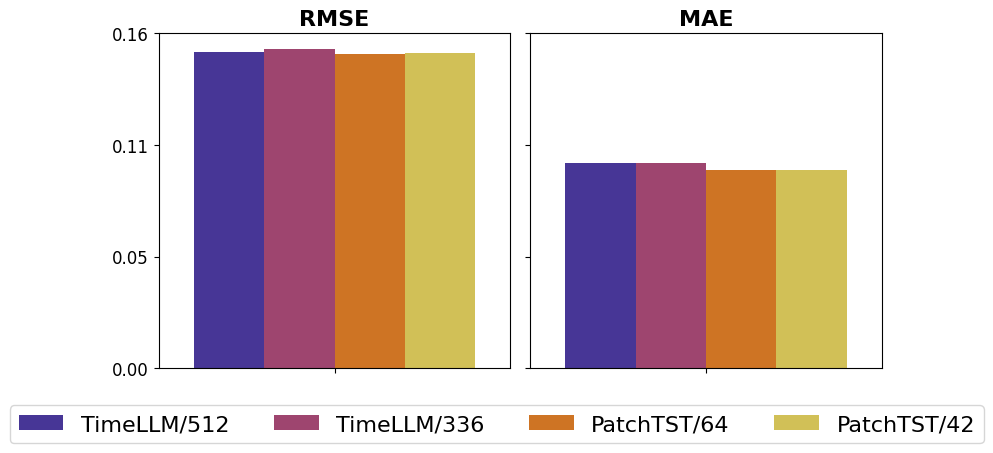

In [43]:
to_group = ['Country', 'Pred_len']
grouped_means = group_and_reindex_df(all_df, to_group=to_group)
plot_barplots(grouped_means, 'Model', col_name='Metrics', palette='CMRmap')

In [ ]:
styled_df.to_html(os.path.join(path, 'timellm_512_10_power_2.html'), index=True)

In [35]:
all_df = pd.concat([timellm_df, patchtst_df], axis=1)

# Change country codes to country names
all_df.index = pd.MultiIndex.from_tuples(
    [(map_country_name(x[0]), x[1]) for x in all_df.index],
    names=level_names
)

# Scale
all_df_scale = all_df * scale

# Highlight minimum values in bold
styled_df = style_dataframe(all_df_scale, decimal_places=2)
styled_df

In [37]:
all_df = pd.concat([timellm_df_336, patchtst_df], axis=1)

# Change country codes to country names
all_df.index = pd.MultiIndex.from_tuples(
    [(map_country_name(x[0]), x[1]) for x in all_df.index],
    names=level_names
)

# Scale
all_df_scale = all_df * scale

# Highlight minimum values in bold
styled_df = style_dataframe(all_df_scale, decimal_places=2)
styled_df

In [38]:
all_df = pd.concat([timellm_df_336, timellm_df], axis=1)

# Change country codes to country names
all_df.index = pd.MultiIndex.from_tuples(
    [(map_country_name(x[0]), x[1]) for x in all_df.index],
    names=level_names
)

# Scale
all_df_scale = all_df * scale

# Highlight minimum values in bold
styled_df = style_dataframe(all_df_scale, decimal_places=2)
styled_df

# 6. Decomposition

In [15]:
decomposition_df = read_results_csv('patchtst/patchtst_decomposition.csv', 
                                    columns_to_extract=('Decomposition', ['RMSE', 'MAE'])
                                    )

#all_df = pd.concat([patchtst_df, decomposition_df], axis=1)

# Change country codes to country names
decomposition_df.index = pd.MultiIndex.from_tuples(
    [(map_country_name(x[0]), x[1]) for x in decomposition_df.index],
    names=level_names
)

# Scale
decomposition_df_scale = decomposition_df * scale
all_df = pd.concat([result_df, decomposition_df_scale], axis=1)

# Highlight the minimum values in bold
styled_df = style_dataframe(all_df, decimal_places=2)
styled_df